## KNN Classifier
The model predicts the severity of the landslide (or if there will even be one) within the next 2 days, based on weather data from the past 5 days.
Binary Classification yielded a maximum accuracy of 77.53%. Severity Classification (multiple classes) was around 56%.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.utils import shuffle
import pickle
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [3]:
df = pd.read_csv("dataset.csv")
len(df)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,11,12,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


17808

In [4]:
df['severity'].value_counts()

medium          5594
small           2612
unknown          834
large            679
...              359
very_large       102
Medium            72
Unknown           19
Large             17
Small             10
catastrophic       4
landslide          2
Very_large         1
Very...large       1
Name: severity, dtype: int64

In [5]:
# filter by severity. na is for non-landslide data
# df = df[df['severity'].isin(["medium", "small", "large", "very_large", "na"])]
# Remove -1 slopes
# df = df.loc[~(df.slope == -1)]
print(len(df))
print(df.forest.value_counts())

17808
1.0    9946
0.0     360
Name: forest, dtype: int64


In [6]:
df['severity'].value_counts()
df = shuffle(df)
df.reset_index(inplace=True, drop=True)
print(len(df))
df

17808


,Unnamed: 0,Unnamed: 0.1,row,Unnamed: 0.1.1,id,date,lat,lon,country,fatalities,...,ARI5,ARI4,ARI3,ARI2,ARI1,ARI0,slope,osm,realosm,lithology
0,6155,6155,6155,6314,5254,11/13/13,8.455700,77.009000,India,0.0,...,2.372216,0.592799,0.269875,5.178485,6.711686,4.213911,12.219,52,43,mt
1,13614,13614,13614,15684,19953,12/2/18,41.523900,49.218300,NaN,NaN,...,0.014589,0.009829,0.203464,0.515335,0.137805,0.328435,0.000,422,0,sm
2,6206,6206,6206,6365,10259,3/16/11,11.134500,124.967700,Philippines,0.0,...,2.110208,4.886791,1.676569,6.136505,2.155440,2.671681,4.825,643,17,su
3,8527,8527,8527,8692,5006,6/13/17,22.257216,114.209272,China,0.0,...,2.097875,1.311118,0.609640,0.280279,4.789782,23.818836,25.853,7897,7,su
4,17156,17156,17156,21213,13677,10/15/13,24.064300,41.909800,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.123,3219,0,mt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803,12334,12334,12334,13687,17194,5/29/18,27.943600,112.268000,NaN,NaN,...,0.312003,2.748366,1.377260,1.147926,0.409544,0.218026,9.548,921,2,mt
17804,11396,11396,11396,12176,18397,1/7/10,42.343600,66.760300,NaN,NaN,...,0.000000,0.396879,0.099220,0.044098,0.157098,0.048948,1.907,490,0,su
17805,16241,16241,16241,19783,18310,1/8/11,-6.823200,71.580900,NaN,NaN,...,0.621123,0.384622,0.730411,1.792151,0.516115,0.223134,0.000,68,0,mt
17806,10100,10100,10100,10272,5281,12/24/13,10.282500,125.576800,Philippines,1.0,...,0.481122,0.629623,2.838618,5.786632,4.975103,2.989486,20.001,1437,67,ss


In [7]:
X = df.copy()
y = X.landslide
columns=[]
for i in range(9, 4, -1):
    columns.append('humidity' + str(i))
    columns.append('ARI' + str(i))
columns.append('slope')
columns.append('forest2')
columns.append('realosm')
columns.append('lithology')
X = X[columns]

In [8]:
lith = dict()
numToLith = dict()
cnt = 0
for lithology in X['lithology']:
    if lithology not in lith:
        lith[lithology] = cnt
        numToLith[cnt] = lithology
        cnt += 1
        print("Added lithology: ", lithology)
lithCol = []
for lithology in X['lithology']:
    lithCol.append(lith[lithology])
X['lithology'] = lithCol
X

Added lithology:  mt
Added lithology:  sm
Added lithology:  su
Added lithology:  sc
Added lithology:  ss
Added lithology:  vi
Added lithology:  wb
Added lithology:  ev
Added lithology:  va
Added lithology:  nd
Added lithology:  pa
Added lithology:  pb
Added lithology:  vb
Added lithology:  ig
Added lithology:  py


,humidity9,ARI9,humidity8,ARI8,humidity7,ARI7,humidity6,ARI6,humidity5,ARI5,slope,forest2,realosm,lithology
0,79,1.214798,79,0.682647,82,0.452137,80,0.640850,80,2.372216,12.219,1,43,0
1,94,0.106349,84,0.168553,92,0.051391,88,0.024125,79,0.014589,0.000,0,0,1
2,99,0.833868,99,0.486477,98,0.912661,98,0.479422,99,2.110208,4.825,1,17,2
3,95,2.083631,96,1.621084,96,0.833002,89,1.800993,88,2.097875,25.853,1,7,2
4,28,0.000000,21,0.000000,24,0.000000,25,0.000000,22,0.000000,1.123,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17803,93,2.258166,97,1.881499,94,1.171545,78,0.514123,75,0.312003,9.548,1,2,0
17804,93,0.000000,96,0.000000,75,0.000000,81,0.000000,62,0.000000,1.907,0,0,2
17805,79,1.381597,83,6.615067,79,2.087551,80,0.959491,80,0.621123,0.000,0,0,0
17806,81,0.456765,83,0.850532,81,0.322103,83,0.407599,83,0.481122,20.001,1,67,4


## Scaling

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = X.to_numpy().tolist()

In [10]:
models = []
folds = []
foldsy = []
def createFolds(numFolds):
    global models
    global folds
    global foldsy
    models = []
    folds = []
    foldsy = []
    for p in range(0, len(X), int(len(X)/numFolds)):
        folds.append(X[p : p + int(len(X)/numFolds)])
        foldsy.append(y[p : p + int(len(y)/numFolds)])
    folds = folds[:numFolds]

In [11]:
def getValidation(numFolds, k):
    vscore = 0
    for kfold in range(numFolds):
        X_train = []
        y_train = []
        for index in range(numFolds):
            if index == kfold: continue
            X_train.extend(folds[index])
            y_train.extend(foldsy[index])
        X_test = folds[kfold]
        y_test = foldsy[kfold]
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)
        vscore += accuracy_score(pred, y_test)
    return vscore/numFolds

In [12]:
def getBest(numFolds, loK, maxK, verbose = False):
    bestK = loK
    bestV = 0
    createFolds(numFolds)
    for k in range(loK, maxK + 1, 2):
        res = getValidation(numFolds, k)
        if(res > bestV):
            bestV = res
            bestK = k
            if verbose:
                print(k, "is better:", res)
    return bestK, bestV

In [13]:
k, val = getBest(10, 5, 199, True)
print("Use: ", k, "=", val)

5 is better: 0.8535393258426967
7 is better: 0.8562921348314607
9 is better: 0.8589325842696629
11 is better: 0.8613483146067417
Use:  11 = 0.8613483146067417


## Prediction

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [15]:
from sklearn.metrics import accuracy_score
pred = knn.predict(X_test)
# class_probabilities = knn.predict_proba()
print("ACCURACY:", accuracy_score(pred, y_test))

ACCURACY: 0.8531723750701853


## Confusion Matrix

In [16]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_test, pred)
array

array([[1238,  264],
       [ 259, 1801]])

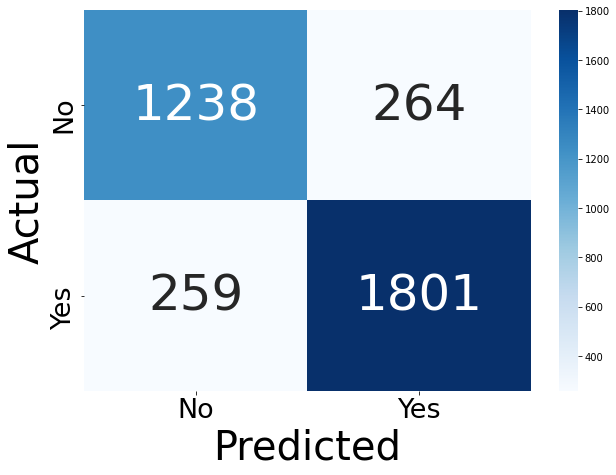

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
binary = True
if binary:
    df_cm = pd.DataFrame(array, index = [i for i in ["No", "Yes"]],
                    columns = [i for i in ["No", "Yes"]])
else:
    df_cm = pd.DataFrame(array, index = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]],
                  columns = [i for i in ["None", "Small", "Medium", "Large", "Very Large"]])

plt.figure(figsize = (10,7))

ax = sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size":50}, fmt='g')
ax.tick_params(axis='both', which='major', labelsize=27)
plt.xlabel('Predicted', fontsize = 40) 
# plt.title("KNN Confusion Matrix", fontsize = 50)
plt.ylabel('Actual', fontsize = 40) 
plt.savefig("Lith Valid KNN Matrix", bbox_inches="tight")

plt.show()